# How batch-normalization affects drug response prediction?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from time import time
from glob import glob
from pprint import pprint

import sklearn
import numpy as np
import pandas as pd

In [2]:
utils_path = os.path.abspath(os.path.join('../'))
sys.path.append(utils_path)

In [3]:
os.getcwd()

'/vol/ml/apartin/projects/LearningCurves/pre_proc'

In [4]:
from utils_pre_proc import scale_rna, plot_pca, map_rna_values_to_cell_lines
from utils_pre_proc import combat_ap
from build_tidy_data import load_rsp, load_rna, load_dsc

In [5]:
# ComBat imports
# import patsy  # for combat
# from combat import combat
%matplotlib inline

# Utils

In [6]:
src_keep = ['ccle', 'nci60']
src_name_map = {'ccle': 'CCLE', 'nci60': 'NCI-60'}
fea_start_id = 1

In [7]:
def check_mapping_cells(df, fea_start_id, cl_mapping):
    d1 = cl_mapping.merge(df, left_on='from_cell', right_on='CELL')
    d1 = d1.sort_values('from_cell')
    d1 = d1.drop(columns=['from_cell', 'to_cell'])
    
    d2 = cl_mapping.merge(df, left_on='to_cell', right_on='CELL')
    d2 = d2.sort_values('from_cell')
    d2 = d2.drop(columns=['from_cell', 'to_cell'])
    
    diff = (d1.iloc[:, fea_start_id:].values - d2.iloc[:, fea_start_id:].values).sum()
    return diff

In [8]:
def src_from_cell_col(cell_name_col, verbose=False):
    """ Takes column that contains cell line names, extract the source name, and returns the arr of source names.
    Prints value_counts if verbose=True. """
    # rna['CELL'].map(lambda x: x.split('.')[0].lower())
    src_names_arr = cell_name_col.map(lambda x: x.split('.')[0].lower())
    src_names_arr.name = 'source'
    if verbose: print(src_names_arr.value_counts())
    return src_names_arr

In [9]:
# Load the cell line mapping
cl_mapping = pd.read_csv('cl_mapping', sep='\t', header=None)
cl_mapping.rename(columns={0: 'from_cell', 1: 'to_cell'}, inplace=True)
print(cl_mapping.shape)
cl_mapping[:2]

(1841, 2)


,from_cell,to_cell
0,CCLE.22RV1,GDSC.22RV1
1,CCLE.2313287,GDSC.23132-87


# Load data

In [10]:
datadir = '../data'

In [11]:
rna = load_rna(datadir, rna_norm='raw')
rna_org = rna.copy()

print(rna.shape)
src_from_cell_col(rna['CELL'], verbose=True);

Cols with missing values (before impute): 0
(2917, 943)
ccle     1018
ctrp      812
gdsc      670
gcsi      357
nci60      60
Name: source, dtype: int64


In [12]:
# Extract sources which contain original RNA-Seq
src_names_arr = src_from_cell_col(rna['CELL'], verbose=False)
rna = rna.loc[ src_names_arr.isin(src_keep) ]
print(rna.shape)
src_from_cell_col(rna['CELL'], verbose=True);

(1078, 943)
ccle     1018
nci60      60
Name: source, dtype: int64


# Raw data

Explained variance by PCA components [1, 2]: [0.13607, 0.11609]


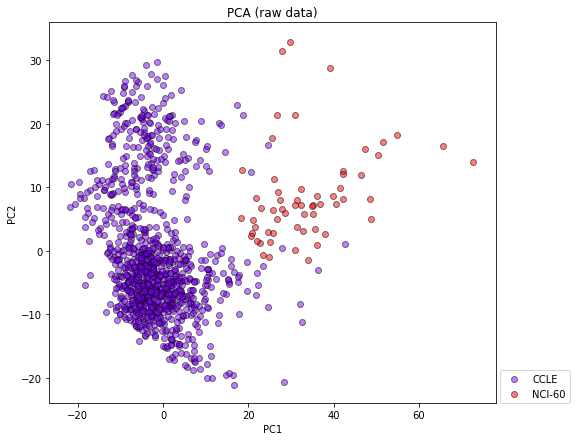

In [13]:
plot_pca(rna.iloc[:, fea_start_id:], components = [1, 2], figsize=(8,7),
         color_vector = rna['CELL'].map(lambda x: src_name_map[x.split('.')[0].lower()]),
         scale=True, title='PCA (raw data)');

In [14]:
print(rna.shape)
rna_raw = map_rna_values_to_cell_lines(rna, cl_mapping)
print(rna_raw.shape)

(1078, 943)
(2919, 943)


In [15]:
check_mapping_cells(rna_raw, fea_start_id=fea_start_id, cl_mapping=cl_mapping)

0.0

# Source scaling

Scaling ccle
Scaling nci60
(1078, 943)
Explained variance by PCA components [1, 2]: [0.12664, 0.09696]


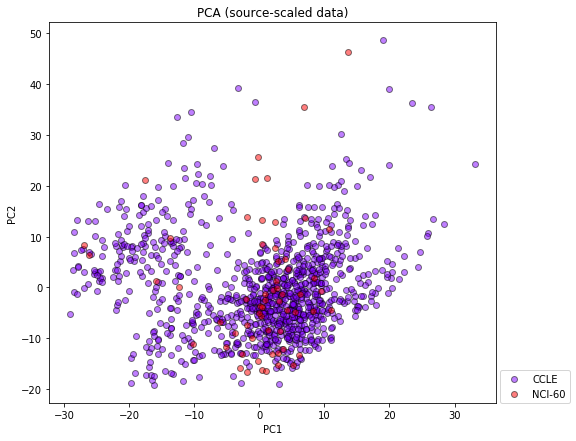

In [14]:
rna_sc = scale_rna(rna, fea_start_id=fea_start_id, per_source=True)
print(rna_sc.shape)

plot_pca(rna_sc.iloc[:, fea_start_id:], components = [1, 2], figsize=(8,7),
         color_vector = rna['CELL'].map(lambda x: src_name_map[x.split('.')[0].lower()]),
         scale=True, title='PCA (source-scaled data)');

In [15]:
display(rna_sc[:2])
print(rna_sc.mean(axis=0).mean())
print(rna_sc.mean(axis=1).mean())
print(rna_sc.var(axis=0).mean())
print(rna_sc.var(axis=1).mean())

,CELL,GE_AARS,GE_ABCB6,GE_ABCC5,GE_ABCF1,GE_ABCF3,GE_ABHD4,GE_ABHD6,GE_ABL1,GE_ACAA1,...,GE_ZMIZ1,GE_ZMYM2,GE_ZNF131,GE_ZNF274,GE_ZNF318,GE_ZNF395,GE_ZNF451,GE_ZNF586,GE_ZNF589,GE_ZW10
0,CCLE.22RV1,0.643460,1.665659,-0.003287,-1.612203,0.440622,-0.603358,-0.688464,-0.259270,0.177445,...,-1.105644,0.636475,0.150561,-0.280040,0.931946,0.295963,1.24120,1.413897,0.753615,0.892602
1,CCLE.2313287,1.464804,1.039212,-0.309370,0.023618,0.332630,1.231317,0.944933,-0.957579,0.930680,...,-0.572183,0.575539,0.609772,-0.104828,-0.055401,-0.619046,1.37306,0.961168,0.649255,1.093517


-3.7918263e-10
-8.8467006e-10
1.0009286
0.9340855


In [16]:
print(rna_sc.shape)
rna_sc = map_rna_values_to_cell_lines(rna_sc, cl_mapping)
print(rna_sc.shape)

(1078, 943)
(2919, 943)


In [17]:
check_mapping_cells(rna_sc, fea_start_id=fea_start_id, cl_mapping=cl_mapping)

0.0

In [18]:
rna_sc = rna_sc.sort_values('CELL')

In [19]:
# Dump files
# filename = DATASET + '_source_scale'
# rna_sc.to_csv(os.path.join(OUTDIR, filename), sep='\t', float_format=np.float32, index=False)

#### Note that there are 2 extra gdsc cell lines added from cl_mapping (??)

In [20]:
rna_sc['CELL'].map(lambda x: x.split('.')[0].lower()).value_counts()

ccle     1018
ctrp      812
gdsc      672
gcsi      357
nci60      60
Name: CELL, dtype: int64

In [21]:
rna_org['CELL'].map(lambda x: x.split('.')[0].lower()).value_counts()

ccle     1018
ctrp      812
gdsc      670
gcsi      357
nci60      60
Name: CELL, dtype: int64

In [22]:
set(rna_sc['CELL'].tolist()) - set(rna_org['CELL'].tolist())

{'GDSC.KMH-2', 'GDSC.T-T'}

# Combat

In [23]:
# Data for combat
meta = src_from_cell_col(rna['CELL'], verbose=False).to_frame()
meta['CELL'] = rna['CELL']

found 2 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
Explained variance by PCA components [1, 2]: [0.12678, 0.09698]


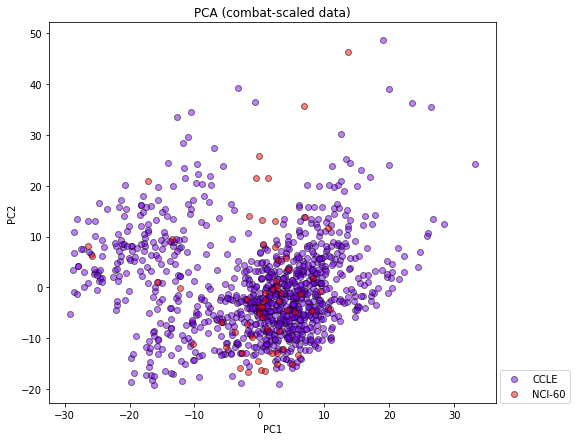

In [24]:
rna_cmbt = combat_ap(rna, meta, sample_col_name='CELL', batch_col_name='source')

plot_pca(rna_cmbt.iloc[:, fea_start_id:], components = [1, 2], figsize=(8,7),
         color_vector = rna['CELL'].map(lambda x: src_name_map[x.split('.')[0].lower()]),
         scale=True, title='PCA (combat-scaled data)');

In [25]:
display(rna_cmbt[:2])
print(rna_cmbt.mean(axis=0).mean())
print(rna_cmbt.mean(axis=1).mean())
print(rna_cmbt.var(axis=0).mean())
print(rna_cmbt.var(axis=1).mean())

,CELL,GE_AARS,GE_ABCB6,GE_ABCC5,GE_ABCF1,GE_ABCF3,GE_ABHD4,GE_ABHD6,GE_ABL1,GE_ACAA1,...,GE_ZMIZ1,GE_ZMYM2,GE_ZNF131,GE_ZNF274,GE_ZNF318,GE_ZNF395,GE_ZNF451,GE_ZNF586,GE_ZNF589,GE_ZW10
0,CCLE.22RV1,8.289125,7.054459,4.057461,5.604701,5.979732,3.853563,2.013755,5.150628,5.175941,...,3.141432,4.877958,4.445541,3.903783,4.706974,1.596116,3.944767,4.159681,3.791930,5.326397
1,CCLE.2313287,8.919947,6.187584,3.769191,6.574284,5.928917,6.245955,3.644009,4.580712,5.722968,...,3.777622,4.828213,4.704345,4.053464,3.970221,1.013483,4.014405,3.790698,3.692614,5.446585


4.8534986156183715
4.8534986156183715
1.547865257765704
3.914171489046857


In [26]:
print(rna_cmbt.shape)
rna_cmbt = map_rna_values_to_cell_lines(rna_cmbt, cl_mapping)
print(rna_cmbt.shape)

(1078, 943)
(2919, 943)


In [27]:
check_mapping_cells(rna_cmbt, fea_start_id=fea_start_id, cl_mapping=cl_mapping)

0.0

In [28]:
rna_cmbt = rna_cmbt.sort_values('CELL')

# Create combined dataset

In [29]:
RSP_FILENAME = 'combined_single_response_agg'  # reposne data
DSC_FILENAME = 'pan_drugs_dragon7_descriptors.tsv'  # drug descriptors data (new)

In [33]:
rsp = load_rsp(filename=Path(datadir)/RSP_FILENAME, src=['ccle', 'nci60'])
print(rsp.shape)
print(rsp.SOURCE.value_counts())

In [38]:
dsc = load_dsc(filename=Path(datadir)/DSC_FILENAME, plot=False)
print(dsc.shape)

Cols with missing values (before impute): 1196
Cols with missing values (after impute): 0


In [41]:
def merge_all(rsp, rna, dsc):
    # # Merge with cmeta
    # print('\nMerge response (rsp) and cell metadata (cmeta) ...')
    # data = pd.merge(rsp, cmeta, on='CELL', how='left') # left join to keep all rsp values
    # print(f'data.shape  {data.shape}\n')
    # print(data.groupby('SOURCE').agg({'CELL': 'nunique'}).reset_index())
    # del rsp

    # # Merge with dmeta
    # print('\nMerge with drug metadata (dmeta) ...')
    # data = pd.merge(data, dmeta, on='DRUG', how='left') # left join to keep all rsp values
    # print(f'data.shape  {data.shape}\n')
    # print(data.groupby('SOURCE').agg({'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index())

    data = rsp.copy()

    # Merge with rna
    print('\nMerge with expression (rna) ...')
    data = pd.merge(data, rna, on='CELL', how='inner') # inner join to keep samples that have rna
    print(f'data.shape {data.shape}\n')
    print(data.groupby('SOURCE').agg({'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index())
    # del rna

    # Merge with dsc
    print('\nMerge with descriptors (dsc) ...')
    data = pd.merge(data, dsc, on='DRUG', how='inner') # inner join to keep samples that have dsc
    print(f'data.shape {data.shape}\n')
    print(data.groupby('SOURCE').agg({'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index())
    # del dsc
    
    return data

In [ ]:
df_raw = merge_all(rsp, dsc=dsc, rna=rna_raw);
# df_sc = merge_all(rsp, dsc=dsc, rna=rna_sc);
# df_cmbt = merge_all(rsp, dsc=dsc, rna=rna_cmbt);

# Train Models

In [ ]:
scores = {}
n_models = 0
for seed in range(n_models):
    # Split data
    pass
    
    # Train model
    pass

    # Agg scores
    scores[seed] = score
    